<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/cnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary modules

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer

## Device agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preparing data

In [3]:
# Downloading the dataset
train_data = FashionMNIST(root='data',
                          train=True,
                          transform=ToTensor(),
                          target_transform=None,
                          download=True)
test_data = FashionMNIST(root='data',
                          train=False,
                          transform=ToTensor(),
                          target_transform=None,
                          download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# Turning datasets into dataloaders
BATCH_SIZE = 32
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [5]:
train_data_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

## Creating the model

In [6]:
from torch.nn.modules.pooling import MaxPool2d
class FMNISTCNNModel1(nn.Module):
    def __init__(self, input_shape, hidden_nodes, output_shape):
        super().__init__()
        self.convbatch1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=(3, 3), # Same as giving the value 3
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.convbatch2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_nodes*7*7,
                      out_features=hidden_nodes,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=hidden_nodes,
                      out_features=output_shape,
                      bias=True,
                      device=device,
                      dtype=torch.float)
        )
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.layer(self.convbatch2(self.convbatch1(x)))


In [7]:
model1 = FMNISTCNNModel1(input_shape=1,
                         hidden_nodes=10,
                         output_shape=10)
model1

FMNISTCNNModel1(
  (convbatch1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convbatch2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

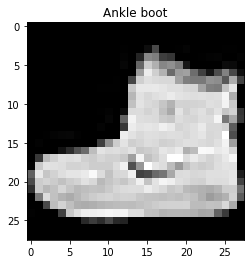

torch.Size([1, 28, 28])

In [8]:
image, label = train_data_loader.dataset[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(train_data_loader.dataset.classes[label])
plt.show()
image.shape

torch.Size([1, 9, 27, 27])

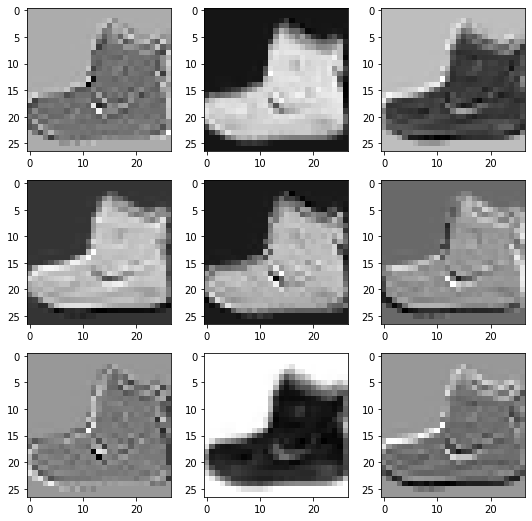

In [9]:
p = nn.Conv2d(in_channels=1,
              out_channels=9,
              kernel_size=2)
# q = nn.ReLU()
# r = nn.Conv2d(in_channels=9,
#               out_channels=9,
#               kernel_size=(5,5))
y = p(image.unsqueeze(0))
plt.figure(figsize=(9,9))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(y[0][i-1].detach(),cmap='gray')
y.shape

In [10]:
result = model1(image.unsqueeze(0).to(device))
result

tensor([[ 0.0688,  0.0859, -0.1662, -0.0543, -0.0117, -0.1831,  0.0253, -0.0283,
          0.0818,  0.1022]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
## Picking a loss function, evalution function and optimizer

def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)


In [12]:
def training_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             optimizer:torch.optim.Optimizer,
             device:torch.device = device):
    
    model = model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0

    for batch, (X_train, y_train) in enumerate(data_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_train)
        train_acc += acc
        model.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} accuracy: {train_acc*100:.3f}%")


def testing_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             device:torch.device = device):
    
    model = model.to(device)
    model.eval()

    test_loss = 0
    test_acc = 0

    with torch.inference_mode():    
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_test)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} accuracy: {test_acc*100:.3f}%")


def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = default_timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"--------------------------------------------------{epoch}--------------------------------------------------------")
    training_step(model=model1,
                  data_loader=train_data_loader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  optimizer=optimizer,
                  device=device)
    testing_step(model=model1,
                 data_loader=test_data_loader,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

end_time = default_timer()

total_train_time = end_time - start_time
print(f"Total train time taken is {total_train_time} using device {device}")

  0%|          | 0/5 [00:00<?, ?it/s]

--------------------------------------------------0--------------------------------------------------------
Train loss: 0.72826 accuracy: 72.595%
Test loss: 0.41023 accuracy: 85.383%
--------------------------------------------------1--------------------------------------------------------
Train loss: 0.36861 accuracy: 86.495%
Test loss: 0.36185 accuracy: 86.981%
--------------------------------------------------2--------------------------------------------------------
Train loss: 0.32472 accuracy: 87.998%
Test loss: 0.32985 accuracy: 88.269%
--------------------------------------------------3--------------------------------------------------------
Train loss: 0.29898 accuracy: 89.057%
Test loss: 0.31364 accuracy: 88.399%
--------------------------------------------------4--------------------------------------------------------
Train loss: 0.28401 accuracy: 89.637%
Test loss: 0.32064 accuracy: 88.379%
Total train time taken is 72.60655044 using device cuda


In [14]:
# Just an audio alarm that informs if colab finished executing. 
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/5/5c/Alarm_clock_-_01.ogg").play()')

In [15]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [16]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

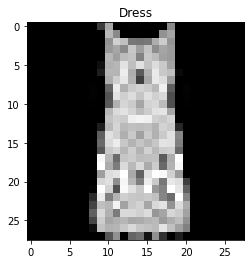

In [17]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(test_data.classes[test_labels[0]])
plt.show()

In [18]:
pred_probs = make_predictions(model=model1,
                              data=test_samples,
                              device=device)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 9, 0, 5, 8, 7, 3, 9, 5])

In [19]:
test_labels

[3, 9, 0, 5, 8, 7, 3, 9, 5]

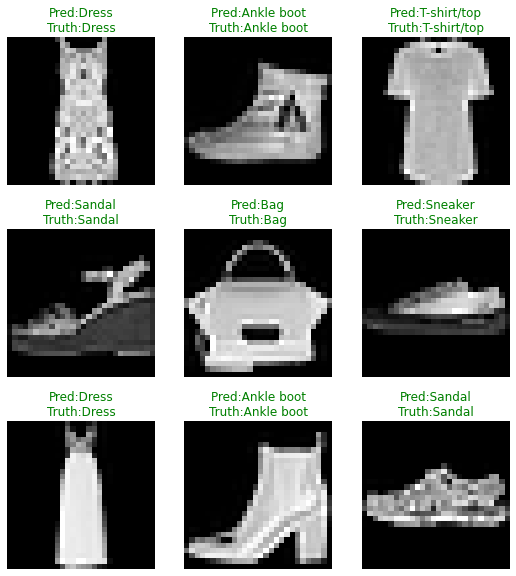

In [20]:
plt.figure(figsize=(9,10))
n_rows = 3
n_cols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = test_data.classes[pred_classes[i]]
    actual_label = test_data.classes[test_labels[i]]
    title = f"Pred:{pred_label}\nTruth:{actual_label}"
    if (pred_label == actual_label):
        plt.title(title, c="g")
    else:
        plt.title(title, c='r')
    plt.axis(False)
plt.show()

In [21]:
full_preds = []

for image, label in tqdm(test_data_loader, desc="Making predictions:"):
    image = image.to(device)
    label = label.to(device)
    pred_logits = model1(image)
    pred_label = torch.softmax(pred_logits.squeeze(), dim=0).argmax(dim=1)
    full_preds.append(pred_label)
# print(full_preds)
full_preds_tensor = torch.cat(full_preds)
print(full_preds_tensor)

Making predictions::   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 0, 1, 0], device='cuda:0')


In [22]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [26]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 13.3 MB/s eta 0:00:00


In [27]:
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [28]:
import torchmetrics
import mlxtend
print(torchmetrics.__version__)
print(mlxtend.__version__)

0.11.3
0.21.0


In [29]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task='multiclass',
                          num_classes=len(test_data.classes))

confusion_matrix = confmat(preds=full_preds_tensor.cpu(),
                           target=test_data.targets)
confusion_matrix

tensor([[565,   5,  23,  36,   6,   0, 357,   0,   8,   0],
        [ 28, 865,   4,  74,  18,   1,   6,   0,   4,   0],
        [ 12,   3, 746,  19, 159,   0,  52,   1,   8,   0],
        [ 46,   3,  13, 839,  40,   0,  55,   0,   4,   0],
        [  1,   9,  89,  47, 800,   0,  44,   0,  10,   0],
        [  2,   3,   0,   3,   1, 826,   5,  80,  52,  28],
        [ 63,   5, 106,  56, 128,   0, 631,   0,  11,   0],
        [  0,   1,   0,   0,   0,  27,   0, 925,  14,  33],
        [ 12,   4,  18,  36,  26,   5,  24,   5, 868,   2],
        [  0,   2,   1,   4,   0,  34,   3, 112,   1, 843]])

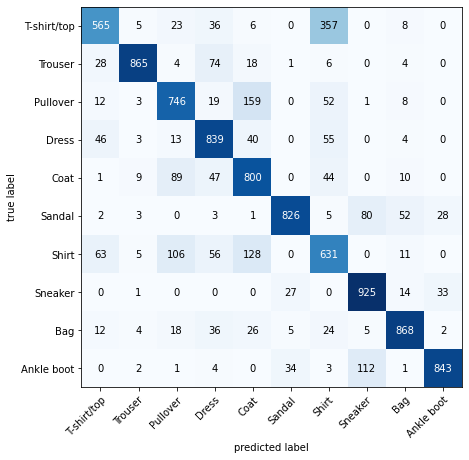

In [30]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.numpy(),
                                figsize=(10,7),
                                class_names=test_data.classes)

## Saving and Loading

In [31]:
from pathlib import Path

MODEL_PATH = Path("Model")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "FashionMNISTModel.pth"

SAVED_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model1.state_dict(),
           f=SAVED_PATH)

In [32]:
model2 = FMNISTCNNModel1(input_shape=1,
                         hidden_nodes=10,
                         output_shape=10)
model2.load_state_dict(state_dict=torch.load(f=SAVED_PATH))
model2.to(device)

FMNISTCNNModel1(
  (convbatch1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convbatch2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)